## Кластеризација података користећи Gaussian mixture модел и Expectation–maximization алгоритам
### Увод
Област ненадгледаног учења, у оквиру машинског учења, бави се алгоритмима који могу да науче одређене обрасце у необележеним подацима. Може се грубо поделити у три подобласти:
* кластеровање
* учење репрезентације
* генеративни модели

Алгоритам који ћемо овом приликом обрадити припада овој првој.

Кластеровање представља препознавање група у датим подацима. Подаци су углавном представљени као вектори, где свака компонента одређује неку особину. Важно је напоменути да те групе нису унапред дате, односно ниједан податак није обележен да припада одређеној групи, проблем се управо састоји у томе да се подаци разврстају на основу њихове репрезентације. Два главна алгоритма која решавају овај задатак су K-means, док је други, софистициранији, предмет нашег интересовања.
### Мешавина нормалних расподела
Као што смо већ рекли, узмимо да се сваки податак који обрађујемо може представити као вектор $\vec{x}$ у $\mathbb{R}^{n}$. Даље, претпоставимо да ти подаци долазе из неке расподеле, нама на почетку непознате. Упркос томе, ми ћемо претпоставити да та расподела одговара мешавини нормалних расподела. Мешавина нормалних расподела представља један пробабилистички модел чија се расподела вероватноће, како име каже, састоји из више нормалних расподела. Као што је познато, нормална расподела у вишедимензионалним просторима одређена је очекиваном вредношћу и матрицом коваријанси. За мешавину $K$ нормалних расподела, наш модел записује се као:
$$p(x) = \sum_{k=1}^{K}\phi_{k} \cdot \mathcal{N}(x | \mu_{k}, \Sigma_{k})$$
Осим већ поменутих очекиваних вредности и матрица коваријанси, као параметри модела улазе и реални коефицијенти $\phi_{k}$, по један за сваку групу. Очигледно је да они у збиру морају дати 1, што се може формално доказати интеграљењем горњег израза по читавом простору и имајући у виду да вероватноће морају да се додају до 1. Са Бејзијанског (или Бајесовског) становишта, ови коефицијенти се могу протумачити као априорне вероватноће да податак припада одговарајућем кластеру.
Задатак који се поставља јесте научити вредности ових параметара, односно конкретан модел, који, лаички речено, највише одговара подацима које имамо. Типичан поступак у овим случајевима јесте наћи вредности параметара које ће максимизовати вредност функције веродостојности за дате податке. Уколико податке обележимо са $x^{(1)}, x^{(2)}, \cdots, x^{(m)}$, функција веродостојности изгледа овако:
$$L = \prod_{i=1}^{m}p\left(x^{(i)}\right)$$
Како је логаритамска функција строго растућа, а збир је погоднији од производа, готово увек се посматра логаритам функције веродостојности:
$$\begin{align*} \log{L} &= \sum_{i=1}^{m}\log{p\left(x^{(i)}\right)} \\ &= \sum_{i=1}^{m}\log{\left(\sum_{k=1}^{K}\phi_{k} \cdot \mathcal{N}\left(x^{(i)} | \mu_{k}, \Sigma_{k}\right)\right)}\end{align*}$$

### Алгоритам максимизације очекивања
Нажалост, оваj проблем је прилично незгодан за решавање с обзиром на збир унутар логаритма. We need another way forward!

Уочимо да бисмо, у случају да за сваки податак знамо ком кластеру припада, лако могли одредити параметре модела. Са друге стране, уколико бисмо знали параметре модела, применом Бајесове теореме бисмо могли да израчунамо вероватноће с којом одређен податак припада сваком од кластера.
Алгоритам максимизације очекивања (скраћено ЕМ) се управо ослања на ту идеју. Свака итерација алгоритма састоји се из два корака: најпре се за сваки податак одреде вероватноће припадности сваком од кластера, а затим се тако добијене вероватноће искористе како би се ажурирали параметри модела. Иако ова процедура не гарантује да ће се доћи до оптималног решења, може се показати да се математичко очекивање функције веродостојности никад не смањује.

### Запрљајмо руке
Најпре ће бити потребно да укључимо неке библиотеке које ће нам бити потребне успут. Затим ћемо дефинисати функцију која рачуна логаритам функције веродостојности.

In [4]:
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))

import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib import image
from scipy.stats import multivariate_normal
from util import plot

def logLikelihood(X: np.ndarray, weights: np.ndarray, means: np.ndarray, covariances: np.ndarray):
    outer = np.zeros(X.shape[0])
    for k in range(len(weights)):
        outer += multivariate_normal.pdf(X, means[k], covariances[k])*weights[k]
    return np.sum(np.log(outer))

### Матрица коваријанси
За загревање, почнимо од функције која рачуна матрицу коваријанси за дате податке $X$ и средње вредности $\mu$. Подаци су представљени у оквиру матрице и поређани по врстама - дакле први податак биће представљен првом врстом, други другом, итд.). Коваријанса између $i$-те и $j$-те компоненте података рачуна се као:
$$\sigma_{ij} = \frac{1}{m}\sum_{k=1}^{m} \left(x_{i}^{(k)}-\mu_{i}\right)\left(x_{j}^{(k)} - \mu_{j}\right)$$
Да бисмо убрзали рачунање, искористићемо матрично множење и библиотеку numpy за нумеричка израчунавања која је високо оптимизована за овакве операције. Уведимо најпре матрицу $\Delta$ са елементима:
$$\delta_{ij} = x_{j}^{(i)} - \mu_{j}$$
Скаларни производ две колоне ове матрице подељен бројем података односно бројем врста даће нам управо коваријансу између одговарајућих компоненти (пробајте да увидите зашто), те матрицу коваријанси можемо добити на следећи начин:
$$\Sigma = \frac{1}{m} \Delta^{T}\Delta.$$
У коду то изгледа овако:

In [5]:
def covMatrix(X: np.ndarray, mean: np.ndarray):
    delta = np.array(X - mean)
    return np.matmul(delta.T, delta) / X.shape[0]

### Е-корак
Пре него што наставимо, потребно је застати накратко. Иако је претходна рачуница била релативно једноставна, кроз њу смо већ увели две важне ствари које ћемо често виђати надаље:
- избегавање писања петљи кроз векторизацију операција кад год је то могуће
- python broadcasting (приметимо да су X и mean из горњег исечка различитих димензија, али је Пајтон умео да се избори са тим)

Време је да имплементирамо први корак који се састоји из одређивања вероватноћа $P\left(z^{(i)} = k| x^{(i)}\right)$ где је $z^{(i)}$ оно што математичари зову случајна променљива која говори ком кластеру припада $i$-ти података. Простим речником, ради се о вероватноћи да $i$-ти податак припада $k$-том кластеру имајући у виду његове "координате" у нашем векторском простору. Пошто се ради о условној вероватноћи, срачунаћемо је применом Бајесове теореме:
$$\gamma_{ik} \equiv P\left(z^{(i)} = k| x^{(i)}\right) = \dfrac{P\left(x^{(i)} | z^{(i)} = k\right)P\left(z^{(i)} = k\right)}{\sum_{j=1}^{K}P\left(x^{(i)} | z^{(i)} = j\right)P\left(z^{(i)} = j\right)},$$
где је:
$$P\left(x^{(i)} | z^{(i)} = k\right) = \frac{1}{\sqrt{(2\pi)^{n}\det\Sigma_{k}}}\exp\left(\left(x^{(i)}-\mu_{k}\right)^{T}\Sigma_{k}^{-1}\left(x^{(i)}-\mu_{k}\right)\right)$$
што представља функцију густине вероватноће нормалне расподеле у више димензија где су $\mu_{k}, \Sigma_{k}$ очекивање и матрица коваријанси за $k$-ти кластер и представљају параметре модела које желимо да научимо. Функција која рачуна матрицу $\Gamma = \{\gamma_{ik}\}$ димензија $m \times K$ дата је у наставку: најпре се рачуна бројилац, а затим се свака од врста дели својим збиром што представља именилац.

In [6]:
def EStep(X: np.ndarray, weights: np.ndarray, means: np.ndarray, covariances: list):
    # dimen(X) = m x n
    # dimen(weights) = K x 1
    # dimen(means) = K x n
    # dimen(covariances) = K x n x n
    K = len(weights)
    gamma = np.zeros((X.shape[0], K))
    for k in range(K):
        gamma[:,k] = multivariate_normal.pdf(X, means[k], covariances[k]) * weights[k]
    return gamma / np.sum(gamma, 1).reshape(X.shape[0], 1)

### M-корак
Други корак у оквиру једне итерације ЕМ алгоритма јесте ажурирање параметара модела тако да што више одговарају претходно срачунатим вероватноћама и то по следећим правилима:
$$\begin{align*} \phi_{k} &= \frac{\sum_{i=1}^{m}\gamma_{ik}}{m}, \\ \mu_{k} &= \frac{\sum_{i=1}^{m}\gamma_{ik}x^{(i)}}{\sum_{i=1}^{m}\gamma_{ik}}, \\ \Sigma_{k} &= \frac{\sum_{i=1}^{m}\gamma_{ik}\left(x^{(i)}-\mu_{k}\right)\left(x^{(i)}-\mu_{k}\right)^{T}}{\sum_{i=1}^{m}\gamma_{ik}}\end{align*}$$
Ове оцене максимизују математичко очекивање логаритма функције веродостојности, али да бисмо задржали ствари једноставним нећемо улазити у тај поступак. Важно је указати на интуитивност добијених једначина:
- априорна вероватноћа да податак припада неком кластеру поставља се за средњу вредност срачунатих вероватноћа за тај кластер
- очекивање (или средња вредност), који је, ваља подсетити, у општем случају вектор, рачуна се поново као тежинска сума података где тежина уз податак зависи од претходно срачунате вероватноће да тај податак припада том кластеру
- матрица коваријанси рачуна се слично, као тежинска сума спољашњег производа вектора одступања од очекивања.

In [7]:
def MStep(X: np.ndarray, gamma: np.ndarray):
    denom = np.sum(gamma, axis=0)
    weights = denom / X.shape[0]
    means = np.matmul(X.T, gamma) / denom
    means = means.T
    covs = np.array([np.matmul((X - means[k]).T, (X - means[k]) * gamma[:,k].reshape(X.shape[0], 1)) / denom[k] for k in range(gamma.shape[1])])
    return weights, means, covs

### Иницијализација
Параметре модела треба иницијализовати на почетку алгоритма. Уколико имамо $K$ кластера логично је на почетку поставити априорне вероватноће на $1/K$. За почетне средње вредности узимамо $K$ насумичних тачака из скупа података. Што се тиче матрица коваријанси, оне ће бити идентичне за сваки кластер, и то биће једнаке дијагоналној матрици која дели дијагоналне елементе са самом матрицом коваријанси података. Ово није једина опција, може се експериментисати с разним начинима.

In [8]:
def initialMeans(X : np.ndarray, K : int):
    rows = np.random.randint(0, X.shape[0]-1, size=K)
    return X[rows][:]

def initialCov(X : np.ndarray, K:int):
    mean = np.average(X, axis=0)
    sigma = covMatrix(X, mean)
    return [np.diag(np.diag(sigma)) for _ in range(K)]
    
def initialWeights(K: int):
    return np.array([1/K for _ in range(K)])

### Први тест
Најпре ћемо проверити наш код на једноставном примеру података о ерупцијама чувеног __[Старог верног](https://en.wikipedia.org/wiki/Old_Faithful)__ гејзира у националном парку Јелоустоун у Вајомингу, САД. У наредном исечку учитавамо податке из .tsv фајла и приказујемо податке. Може се уочити да је расподела бимодусна и самим тим погодна за тестирање нашег алгоритма.

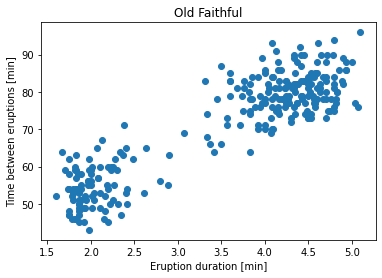

In [9]:
with open('../data/oldFaithful.tsv') as file:
    tsv = csv.reader(file, delimiter='\t')
    cnt = 0
    oldFaithful = [] 
    for line in tsv:
        if cnt != 0:
            oldFaithful.append([float(s) for s in line])
        cnt+=1
data = np.array(oldFaithful)

plt.scatter(data[:,0], data[:,1])
plt.title('Old Faithful')
plt.xlabel('Eruption duration [min]')
plt.ylabel('Time between eruptions [min]')
plt.show()

Сада ћемо пустити алгоритам да покуша да сам препозна и издвоји ова два кластера. Алгоритам ће итерирати све док апсолутна вредност промене логаритма веродостојности не буде мања од $10^{-5}$. На графицима су приказана очекивања за оба кластера, као и тзв. елипсе једне сигме које ближе илуструју одговарајућу расподелу. Резултати су одлични, проблем је успешно решен за само 10 итерација. Промена логаритма функције веродостојности је такође приказана и може се видети како константно опада. Шта се дешава уколико променимо параметар $K$, односно претпостављени број кластера? Пробајте!

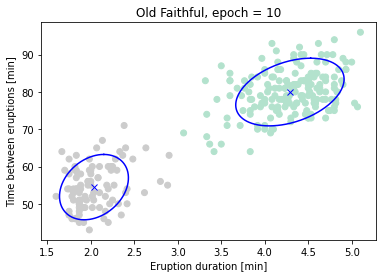

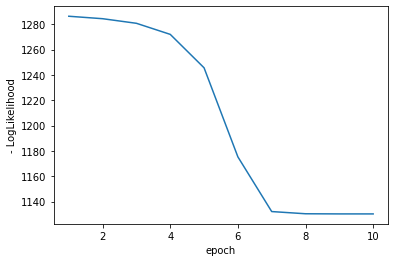

In [10]:
np.random.seed(5555)
K = 2
mu = initialMeans(data, K)
cov = initialCov(data, K)
weights = initialWeights(K)
threshold = 1e-2
ll = float('inf')
epoch = 0
ll_history = []
showIntermediate = False
while True:
    epoch += 1
    gamma = EStep(data, weights, mu, cov)
    if showIntermediate and epoch % 5 == 1:
        # plot!
        plot({
            'data': data,
            'predictions': np.argmax(gamma, axis=1),
            'mu': mu,
            'cov': cov,
            'epoch': epoch,
            'title': 'Old Faithful',
            'xlabel': 'Eruption duration [min]',
            'ylabel': 'Time between eruptions [min]'
        })
    weights, mu, cov = MStep(data, gamma)
    newLl = logLikelihood(data, weights, mu, cov)
    ll_history.append(-newLl)
    if abs(newLl - ll) < threshold:
        break
    ll = newLl
    
    # remove elements
    toDel = []
    for w in range(len(weights)):
        if weights[w] < 1/(2*K):
            toDel.append(w)
    weights = np.delete(weights, toDel, axis=0)
    mu = np.delete(mu, toDel, axis=0)
    cov = np.delete(cov, toDel, axis=0)

plot({
    'data': data,
    'predictions': np.argmax(gamma, axis=1),
    'mu': mu,
    'cov': cov,
    'epoch': epoch,
    'title': 'Old Faithful',
    'xlabel': 'Eruption duration [min]',
    'ylabel': 'Time between eruptions [min]'
})
plt.plot(np.arange(1, epoch+1), ll_history)
plt.xlabel('epoch')
plt.ylabel('- LogLikelihood')
plt.show()

Ако сте пробали да промените вредност $К$ уочили сте да смо уметнули механизам који настоји да одбаци кластере чија је априорна вероватноћа мала у односу на остале. У пракси, уколико унапред није познат број кластера, алгоритам се покреће за различите вредности и бира варијанта која највише одговара.

### Компресија слике
Сада ћемо испробати један необичан пример примене кластеровања - компресија слика! Идеја је да учитамо слику, посматрамо пикселе као тачке у 3-димензионалном RGB простору и покушамо да их сврстамо у, рецимо, 16 кластера. Очекивања, односно центри, тих кластера представљаће боје, а сваки пиксел ћемо пребојити у боју кластера коме припада с највећом вероватноћом. Најпре, погледајмо слику.

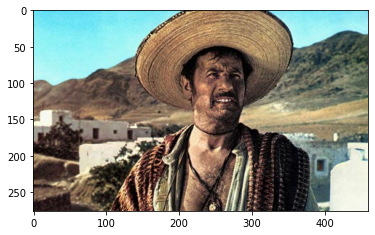

In [16]:
# load and preview image
img = image.imread('../data/tuco.jpg')
plt.imshow(img)
plt.show()

Затим ћемо слику "развити" тако да буде матрица димензија $\left(\text{width}\cdot\text{height}\right) \times 3$ и покренути алгоритам над њом. График приказује кластере који су се формирали у РГБ простору.

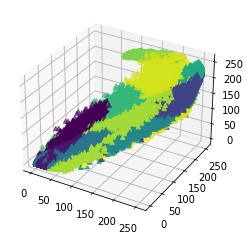

In [21]:
data = img.reshape(img.shape[0]*img.shape[1], 3)
np.random.seed(20)
K = 16
mu = initialMeans(data, K)
cov = initialCov(data, K)
weights = initialWeights(K)
threshold = 1
ll = float('inf')
epoch = 0
ll_history = []
#plot(x_train, mu, cov)
while epoch < 30:
    epoch += 1
    gamma = EStep(data, weights, mu, cov)
    weights, mu, cov = MStep(data, gamma)
    newLl = logLikelihood(data, weights, mu, cov)
    ll_history.append(-newLl)
    if abs(newLl - ll) < threshold:
        break
    ll = newLl

gamma = EStep(data, weights, mu, cov)
fig = plt.figure()
max = np.argmax(gamma, axis=1)
ax = fig.add_subplot(projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=max, cmap='viridis', marker='^')
plt.show()

Коначно, приказујемо добијену компресовану слику. Not too bad! Не заборавите да, уколико имамо 16 кластера, слика димензија 1200x800 која заузима приближно 2.81 мегабајта може бити представљена преко само $1200\times800\times\frac{1}{2} + 16\times3 \approx 469$ килобајта, што је скоро 6 пута мање.

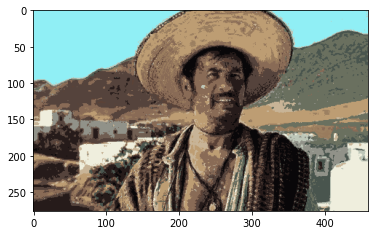

In [22]:
nearestC = np.argmax(gamma, axis=1)
newImg = np.zeros(data.shape)
for i in range(data.shape[0]):
    newImg[i,:] = mu[nearestC[i]]/255
r = newImg.reshape(img.shape[0], img.shape[1], 3)
plt.imshow(r)
plt.show()

Оно што се да приметити са претходног графика јесте да су већина тачака сконцентрисане око једне равни. Код рада са подацима у далеко више димензија још чешће се срећемо са ситуацијом да подаци припадају неком потпростору мање димензионалности. У том случају је погодно најпре одрадити редукцију димензија помоћу математичке технике зване Анализа главних компоненти. Нећемо улазити у детаље овог алгоритма, само ћемо споменути да се он састоји у налажењу сопствених вектора матрице коваријанси података. Након што тако "упрошћене" податке провучемо кроз ЕМ алгоритам, враћамо се назад у оригинални простор.

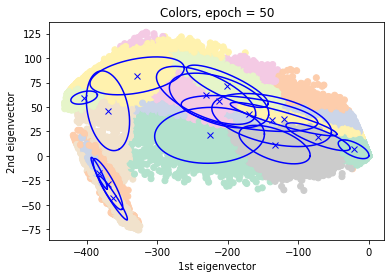

In [23]:
# PCA
u,s,v = np.linalg.svd(np.cov(data.T))
u_red = u[:,:2]
data_red = np.matmul(data, u_red)

# EM algorithm
K = 16
mu = initialMeans(data_red, K)
cov = initialCov(data_red, K)
weights = initialWeights(K)
threshold = 1
ll = float('inf')
epoch = 0
ll_history = []
while epoch < 50:
    epoch += 1
    gamma = EStep(data_red, weights, mu, cov)
    weights, mu, cov = MStep(data_red, gamma)
    newLl = logLikelihood(data_red, weights, mu, cov)
    ll_history.append(-newLl)
    if abs(newLl - ll) < threshold:
        break
    ll = newLl

# plot
gamma = EStep(data_red, weights, mu, cov)
plot({
    'data': data_red,
    'predictions': np.argmax(gamma, axis=1),
    'mu': mu,
    'cov': cov,
    'epoch': epoch,
    'title': 'Colors',
    'xlabel': '1st eigenvector',
    'ylabel': '2nd eigenvector'
})

Извршавањем исечка испод приказаће се слика након овакве компресије. Слика је мало гора него она коју добијамо директним радом над 3Д тачкама, али то је цена која се плаћа за мању димензионалност и већу брзину.

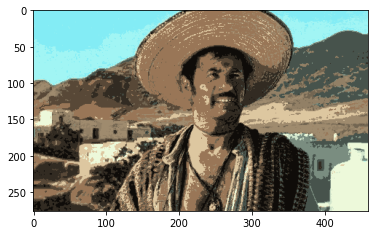

In [24]:
# display compressed image
nearestC = np.argmax(gamma, axis=1)
colors = np.matmul(mu, u_red.T)
newImg = np.zeros(data.shape)
for i in range(data.shape[0]):
    newImg[i,:] = colors[nearestC[i]]/255
r = newImg.reshape(img.shape[0], img.shape[1], 3)
plt.imshow(r)
plt.show()

На крају ипак треба нагласити да овај алгоритам има својих мана. Операције као што су инвертовање матрице и рачунање детерминанте на које се наилази током рачунања гаусијана постају јако скупе како број компоненти и кластера расте. Зато је потребно мудро бирати, што значи одлучити се за ЕМ алгоритам једино у случају када нисмо задовољни резултатом K means алгоритма и имамо разлоге да верујемо да ће он бити бољи. Дакле, увек треба почети са једноставнијим моделом, а тек касније евенутално прећи на сложенији. На пример, у случају слика K means алгоритам би био сасвим довољан. 